## Evaluation and Visualisation of Results on PLAsTiCC with `t2` + Z feats

In [1]:
import argparse
import joblib
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import shutil
import sys
import seaborn as sns
import tensorflow as tf

from itertools import cycle
from numpy import interp
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from tensorflow import keras

from astronet.constants import astronet_working_directory as asnwd
from astronet.preprocess import one_hot_encode
from astronet.utils import astronet_logger, load_dataset

In [2]:
from astronet.metrics import WeightedLogLoss
from astronet.visualise_results import plot_acc_history, plot_confusion_matrix, plot_loss_history, plot_multiROC, plot_multiPR

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

import random as python_random
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(RANDOM_SEED)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"]})

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [4]:
mpl.style.use("seaborn-whitegrid")

In [5]:
architecture = "t2"

In [6]:
dataset = "plasticc"

In [7]:
X_train, y_train, X_test, y_test, loss, Z_train, Z_test = load_dataset(dataset, redshift=True, augmented=None)

In [8]:
num_classes = y_train.shape[1]
num_classes

14

In [9]:
model_name = "1613551066-32f3933"
# model_name = "1613501905-d5b52ec"
# model_name = None

with open(f"{asnwd}/astronet/{architecture}/models/{dataset}/results_with_z.json") as f:
    events = json.load(f)
    if model_name is not None:
    # Get params for model chosen with cli args
        event = next(item for item in events['training_result'] if item["name"] == model_name)
    else:
        # Get params for best model with lowest loss
        event = min(
            (item for item in events["training_result"] if item["augmented"] is None),
                key=lambda ev: ev["model_evaluate_on_test_loss"],
            )

#         event = min(events['training_result'], key=lambda ev: ev['model_evaluate_on_test_loss'])

In [10]:
# Show short summary of items in 'event'
dict(list(event.items())[1:4])

{'augmented': None, 'droprate': 0.1, 'embed_dim': 32}

In [11]:
model_name = event['name']
model_name

'1613551066-32f3933'

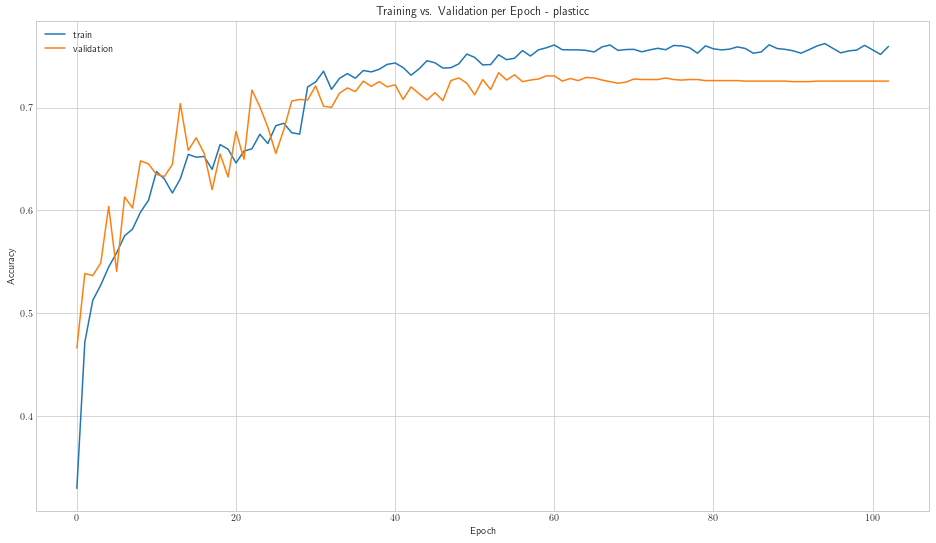

In [12]:
plot_acc_history(dataset, model_name, event, save=False)

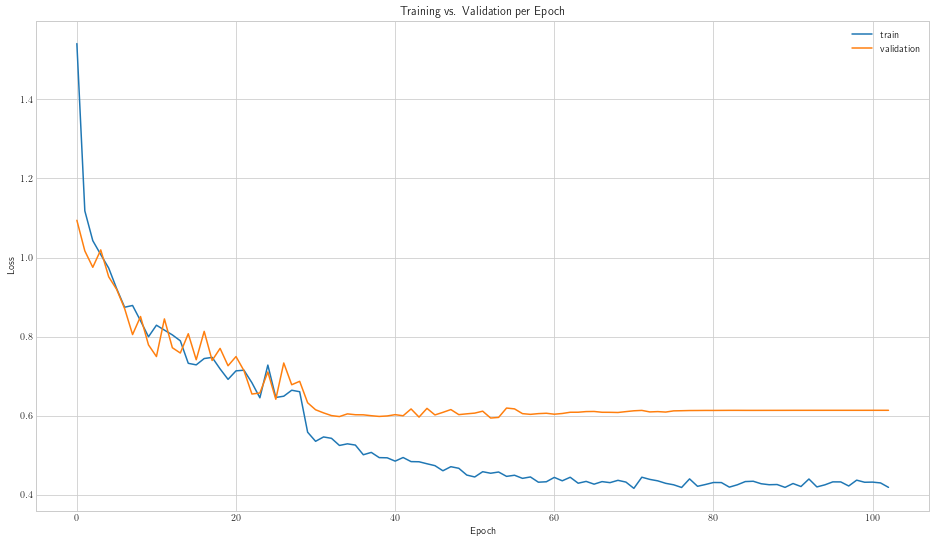

In [13]:
plot_loss_history(dataset, model_name, event, save=False)

In [54]:
model = keras.models.load_model(f"{asnwd}/astronet/{architecture}/models/{dataset}/model-{model_name}", 
                                custom_objects={'WeightedLogLoss': WeightedLogLoss()}, 
                               compile=False)

In [15]:
with open(f"{asnwd}/data/full-{dataset}.encoding", "rb") as eb:
    encoding = joblib.load(eb)
class_encoding = encoding.categories_[0]

if dataset == "plasticc":
    class_mapping = {
        90: "SNIa",
        67: "SNIa-91bg", 
        52: "SNIax",
        42: "SNII",
        62: "SNIbc",
        95: "SLSN-I",
        15: "TDE",
        64: "KN",
        88: "AGN",
        92: "RRL",
        65: "M-dwarf",
        16: "EB",
        53: "Mira",
        6: "$\mu$-Lens-Single",
    }
    class_encoding
    class_names = list(np.vectorize(class_mapping.get)(class_encoding))
else:

    class_names = class_encoding

In [16]:
from collections import Counter
from pandas.core.common import flatten

y_true = encoding.inverse_transform(y_train)
Counter(list(flatten(y_true)))

Counter({95: 126,
         15: 383,
         42: 879,
         90: 1733,
         16: 697,
         65: 735,
         52: 139,
         62: 370,
         67: 161,
         53: 21,
         88: 277,
         92: 183,
         6: 110,
         64: 71})

In [57]:
logloss = event["model_evaluate_on_test_loss"]
acc = event["model_evaluate_on_test_acc"]
print(f"LogLoss on Test Set: {logloss}, Accuracy on Test Set: {acc}")

wloss = WeightedLogLoss()

y_preds = model.predict([X_test, Z_test])
print(f"LL-Test: {wloss(y_test, y_preds).numpy():.2f}")

y_preds_train = model.predict([X_train, Z_train])
print(f"LL-Train: {wloss(y_train, y_preds_train).numpy():.2f}")
# Note the discreptancy seems to be down to inconsistant seeds - see 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

LogLoss on Test Set: 0.6840900182723999, Accuracy on Test Set: 0.7176350951194763
LL-Test: 0.68
LL-Train: 0.44


In [18]:
from astronet.metrics import FlatWeightedLogLoss
fwloss = FlatWeightedLogLoss()

y_preds = model.predict([X_test, Z_test])
print(f"LL-Test: {fwloss(y_test, y_preds).numpy():.2f}")

y_preds_train = model.predict([X_train, Z_train])
print(f"LL-Train: {fwloss(y_train, y_preds_train).numpy():.2f}")
# Note the discreptancy seems to be down to inconsistant seeds - see 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

LL-Test: 0.81
LL-Train: 0.66


In [51]:
model.evaluate([X_test, Z_test])

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

1613551066-32f3933


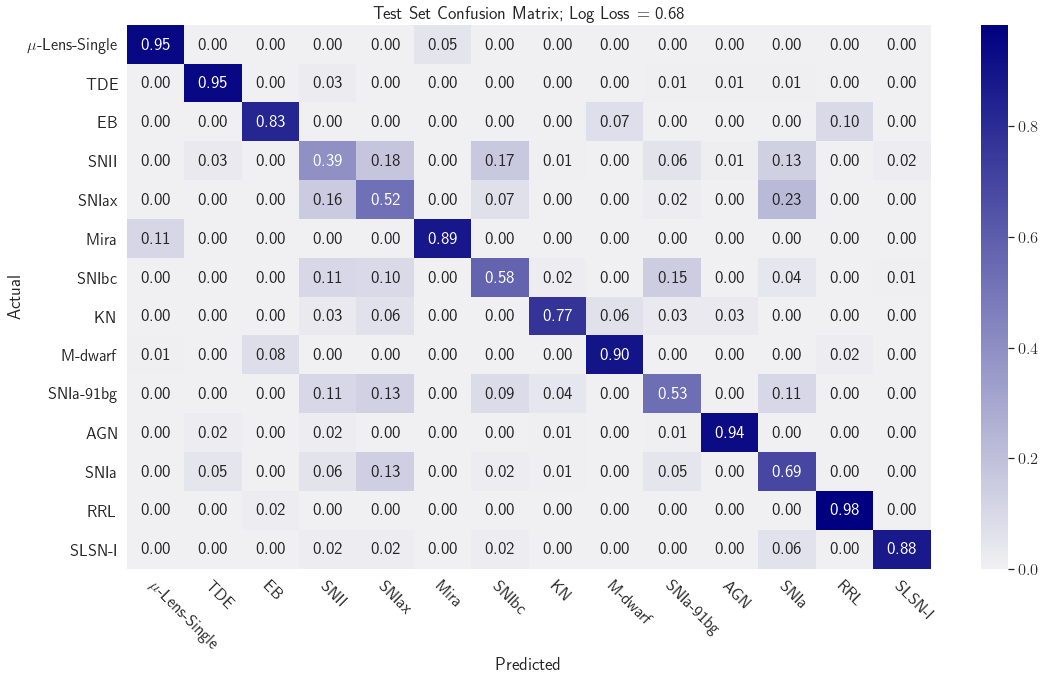

In [19]:
cmap = sns.light_palette("Navy", as_cmap=True)
plot_confusion_matrix(
    dataset,
    model_name,
    y_test,
    y_preds,
    encoding, 
    class_names,  # enc.categories_[0]
    save=False,
    cmap=cmap
)

In [20]:
colors=plt.cm.Accent.colors

1613551066-32f3933


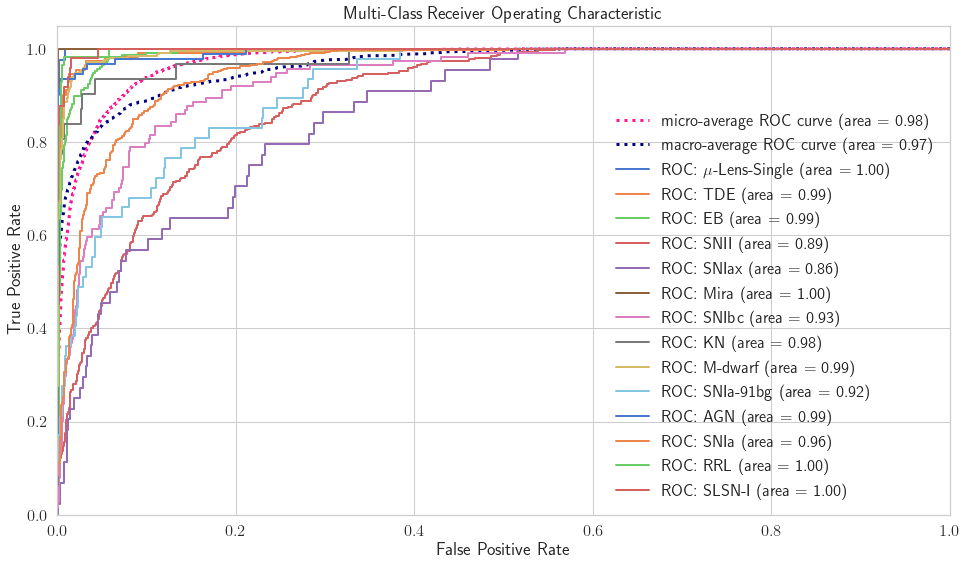

In [21]:
plot_multiROC(dataset, model_name, model, [X_test, Z_test], y_test, class_names, save=False, colors=colors)

In [22]:
colors=plt.cm.tab20.colors

1613551066-32f3933


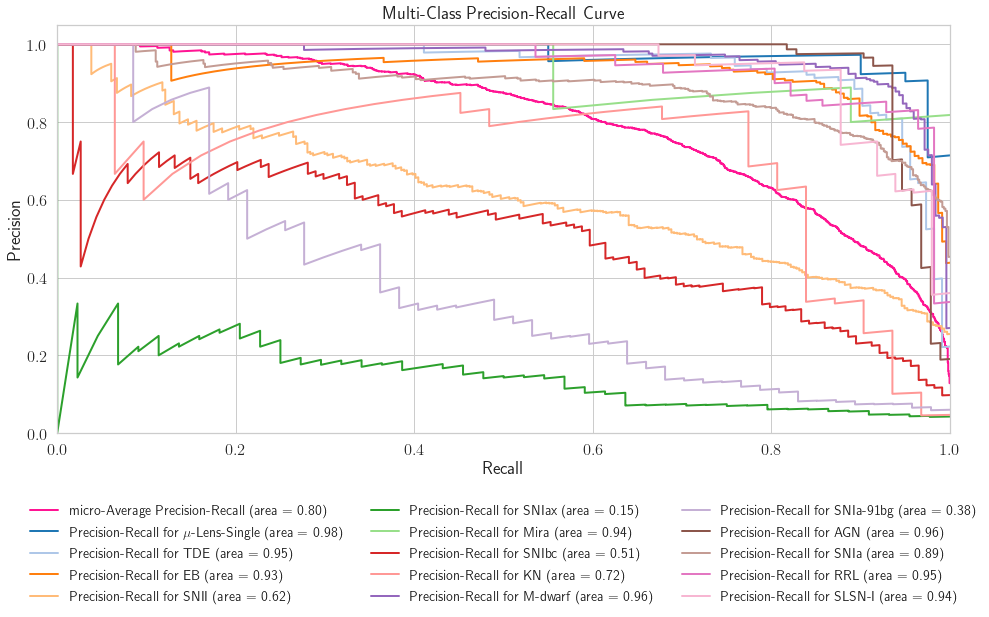

In [23]:
plot_multiPR(dataset, model_name, model, [X_test, Z_test], y_test, class_names, save=False, colors=colors)

## `snmachine` Benchmark Comparisons

As mentioned in https://github.com/tallamjr/astronet/issues/44 one would like to compare performance with the reuslts shown below:
    
<img src="https://user-images.githubusercontent.com/8843728/101194521-04c46800-3656-11eb-9b8c-fc2f30f88cf5.png" width="800">

> The goal would be to compare with the table below, specifically **LL_test**, with and without redshift (**z**) information:

From the results obtained for the `t2` model, a weighted log-loss score of $$LL_{test} = 0.68$$ as well as $$LL_{train} = 0.44$$

The AUC measurements for $AUC_{test}$ only, since we have only evaluated on the test set are: <br>
$$AUC_{test}SNIa = 0.96$$

# Evaluatate on Full Test Set

#### Load first batch file

In [24]:
# X_full_test = np.load(
#         f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_X_test_plasticc_test_lightcurves_01.npy",
# )    

In [25]:
# batch_filename = [
#     "plasticc_test_lightcurves_02_chunk_0",
#     "plasticc_test_lightcurves_02_chunk_1",
#     "plasticc_test_lightcurves_02_chunk_2",
#     "plasticc_test_lightcurves_02_chunk_3",
#     "plasticc_test_lightcurves_02_chunk_4",
#     "plasticc_test_lightcurves_02_chunk_5",
#     "plasticc_test_lightcurves_02_chunk_6",
#     "plasticc_test_lightcurves_02_chunk_7",
#     "plasticc_test_lightcurves_02_chunk_8",
#     "plasticc_test_lightcurves_02_chunk_9",
# #     "plasticc_test_lightcurves_02_chunk_10", # missing ?
#     "plasticc_test_lightcurves_02_chunk_11",
#     "plasticc_test_lightcurves_02_chunk_12",
#     "plasticc_test_lightcurves_02_chunk_13",
#     "plasticc_test_lightcurves_02_chunk_14",
#     "plasticc_test_lightcurves_02_chunk_15",
#     "plasticc_test_lightcurves_02_chunk_16",
#     "plasticc_test_lightcurves_02_chunk_17",
#     "plasticc_test_lightcurves_02_chunk_18",
#     "plasticc_test_lightcurves_02_chunk_19",
#     "plasticc_test_lightcurves_02_chunk_20",
#     "plasticc_test_lightcurves_02_chunk_21",
#     "plasticc_test_lightcurves_02_chunk_22",
#     "plasticc_test_lightcurves_02_chunk_23",
#     "plasticc_test_lightcurves_02_chunk_24",
#     "plasticc_test_lightcurves_02_chunk_25",
#     "plasticc_test_lightcurves_02_chunk_26",
#     "plasticc_test_lightcurves_02_chunk_27",
#     "plasticc_test_lightcurves_02_chunk_28",
#     "plasticc_test_lightcurves_02_chunk_29",
#     "plasticc_test_lightcurves_02_chunk_30",
#     "plasticc_test_lightcurves_02_chunk_31",
#     "plasticc_test_lightcurves_02_chunk_32",
#     "plasticc_test_lightcurves_02_chunk_33",
#     "plasticc_test_lightcurves_02_chunk_34",
#     "plasticc_test_lightcurves_03_chunk_0",
#     "plasticc_test_lightcurves_03_chunk_1",
#     "plasticc_test_lightcurves_03_chunk_2",
#     "plasticc_test_lightcurves_03_chunk_3",
#     "plasticc_test_lightcurves_03_chunk_4",
#     "plasticc_test_lightcurves_03_chunk_5",
#     "plasticc_test_lightcurves_03_chunk_6",
#     "plasticc_test_lightcurves_03_chunk_7",
#     "plasticc_test_lightcurves_03_chunk_8",
#     "plasticc_test_lightcurves_03_chunk_9",
#     "plasticc_test_lightcurves_03_chunk_10",
#     "plasticc_test_lightcurves_03_chunk_11",
#     "plasticc_test_lightcurves_03_chunk_12",
#     "plasticc_test_lightcurves_03_chunk_13",
#     "plasticc_test_lightcurves_03_chunk_14",
#     "plasticc_test_lightcurves_03_chunk_15",
#     "plasticc_test_lightcurves_03_chunk_16",
#     "plasticc_test_lightcurves_03_chunk_17",
#     "plasticc_test_lightcurves_03_chunk_18",
#     "plasticc_test_lightcurves_03_chunk_19",
#     "plasticc_test_lightcurves_03_chunk_20",
#     "plasticc_test_lightcurves_03_chunk_21",
#     "plasticc_test_lightcurves_03_chunk_22",
#     "plasticc_test_lightcurves_03_chunk_23",
#     "plasticc_test_lightcurves_03_chunk_24",
#     "plasticc_test_lightcurves_03_chunk_25",
#     "plasticc_test_lightcurves_03_chunk_26",
#     "plasticc_test_lightcurves_03_chunk_27",
#     "plasticc_test_lightcurves_03_chunk_28",
#     "plasticc_test_lightcurves_03_chunk_29",
#     "plasticc_test_lightcurves_03_chunk_30",
#     "plasticc_test_lightcurves_03_chunk_31",
#     "plasticc_test_lightcurves_03_chunk_32",
#     "plasticc_test_lightcurves_03_chunk_33",
#     "plasticc_test_lightcurves_03_chunk_34",
#     "plasticc_test_lightcurves_04_chunk_0",
#     "plasticc_test_lightcurves_04_chunk_1",
#     "plasticc_test_lightcurves_04_chunk_2",
#     "plasticc_test_lightcurves_04_chunk_3",
#     "plasticc_test_lightcurves_04_chunk_4",
#     "plasticc_test_lightcurves_04_chunk_5",
#     "plasticc_test_lightcurves_04_chunk_6",
#     "plasticc_test_lightcurves_04_chunk_7",
#     "plasticc_test_lightcurves_04_chunk_8",
#     "plasticc_test_lightcurves_04_chunk_9",
#     "plasticc_test_lightcurves_04_chunk_10",
#     "plasticc_test_lightcurves_04_chunk_11",
#     "plasticc_test_lightcurves_04_chunk_12",
#     "plasticc_test_lightcurves_04_chunk_13",
#     "plasticc_test_lightcurves_04_chunk_14",
#     "plasticc_test_lightcurves_04_chunk_15",
#     "plasticc_test_lightcurves_04_chunk_16",
#     "plasticc_test_lightcurves_04_chunk_17",
#     "plasticc_test_lightcurves_04_chunk_18",
#     "plasticc_test_lightcurves_04_chunk_19",
#     "plasticc_test_lightcurves_04_chunk_20",
#     "plasticc_test_lightcurves_04_chunk_21",
#     "plasticc_test_lightcurves_04_chunk_22",
#     "plasticc_test_lightcurves_04_chunk_23",
#     "plasticc_test_lightcurves_04_chunk_24",
#     "plasticc_test_lightcurves_04_chunk_25",
#     "plasticc_test_lightcurves_04_chunk_26",
#     "plasticc_test_lightcurves_04_chunk_27",
#     "plasticc_test_lightcurves_04_chunk_28",
#     "plasticc_test_lightcurves_04_chunk_29",
#     "plasticc_test_lightcurves_04_chunk_30",
#     "plasticc_test_lightcurves_04_chunk_31",
#     "plasticc_test_lightcurves_04_chunk_32",
#     "plasticc_test_lightcurves_04_chunk_33",
#     "plasticc_test_lightcurves_04_chunk_34",
#     "plasticc_test_lightcurves_05_chunk_0",
#     "plasticc_test_lightcurves_05_chunk_1",
#     "plasticc_test_lightcurves_05_chunk_2",
#     "plasticc_test_lightcurves_05_chunk_3",
#     "plasticc_test_lightcurves_05_chunk_4",
#     "plasticc_test_lightcurves_05_chunk_5",
#     "plasticc_test_lightcurves_05_chunk_6",
#     "plasticc_test_lightcurves_05_chunk_7",
#     "plasticc_test_lightcurves_05_chunk_8",
#     "plasticc_test_lightcurves_05_chunk_9",
#     "plasticc_test_lightcurves_05_chunk_10",
#     "plasticc_test_lightcurves_05_chunk_11",
#     "plasticc_test_lightcurves_05_chunk_12",
#     "plasticc_test_lightcurves_05_chunk_13",
#     "plasticc_test_lightcurves_05_chunk_14",
#     "plasticc_test_lightcurves_05_chunk_15",
#     "plasticc_test_lightcurves_05_chunk_16",
#     "plasticc_test_lightcurves_05_chunk_17",
#     "plasticc_test_lightcurves_05_chunk_18",
#     "plasticc_test_lightcurves_05_chunk_19",
#     "plasticc_test_lightcurves_05_chunk_20",
#     "plasticc_test_lightcurves_05_chunk_21",
#     "plasticc_test_lightcurves_05_chunk_22",
#     "plasticc_test_lightcurves_05_chunk_23",
#     "plasticc_test_lightcurves_05_chunk_24",
#     "plasticc_test_lightcurves_05_chunk_25",
#     "plasticc_test_lightcurves_05_chunk_26",
#     "plasticc_test_lightcurves_05_chunk_27",
#     "plasticc_test_lightcurves_05_chunk_28",
#     "plasticc_test_lightcurves_05_chunk_29",
#     "plasticc_test_lightcurves_05_chunk_30",
#     "plasticc_test_lightcurves_05_chunk_31",
#     "plasticc_test_lightcurves_05_chunk_32",
#     "plasticc_test_lightcurves_05_chunk_33",
#     "plasticc_test_lightcurves_05_chunk_34",
#     "plasticc_test_lightcurves_06_chunk_0",
#     "plasticc_test_lightcurves_06_chunk_1",
#     "plasticc_test_lightcurves_06_chunk_2",
#     "plasticc_test_lightcurves_06_chunk_3",
#     "plasticc_test_lightcurves_06_chunk_4",
#     "plasticc_test_lightcurves_06_chunk_5",
#     "plasticc_test_lightcurves_06_chunk_6",
#     "plasticc_test_lightcurves_06_chunk_7",
#     "plasticc_test_lightcurves_06_chunk_8",
#     "plasticc_test_lightcurves_06_chunk_9",
#     "plasticc_test_lightcurves_06_chunk_10",
#     "plasticc_test_lightcurves_06_chunk_11",
#     "plasticc_test_lightcurves_06_chunk_12",
#     "plasticc_test_lightcurves_06_chunk_13",
#     "plasticc_test_lightcurves_06_chunk_14",
#     "plasticc_test_lightcurves_06_chunk_15",
#     "plasticc_test_lightcurves_06_chunk_16",
#     "plasticc_test_lightcurves_06_chunk_17",
#     "plasticc_test_lightcurves_06_chunk_18",
#     "plasticc_test_lightcurves_06_chunk_19",
#     "plasticc_test_lightcurves_06_chunk_20",
#     "plasticc_test_lightcurves_06_chunk_21",
#     "plasticc_test_lightcurves_06_chunk_22",
#     "plasticc_test_lightcurves_06_chunk_23",
#     "plasticc_test_lightcurves_06_chunk_24",
#     "plasticc_test_lightcurves_06_chunk_25",
#     "plasticc_test_lightcurves_06_chunk_26",
#     "plasticc_test_lightcurves_06_chunk_27",
#     "plasticc_test_lightcurves_06_chunk_28",
#     "plasticc_test_lightcurves_06_chunk_29",
#     "plasticc_test_lightcurves_06_chunk_30",
#     "plasticc_test_lightcurves_06_chunk_31",
#     "plasticc_test_lightcurves_06_chunk_32",
#     "plasticc_test_lightcurves_06_chunk_33",
#     "plasticc_test_lightcurves_06_chunk_34",
#     "plasticc_test_lightcurves_07_chunk_0",
#     "plasticc_test_lightcurves_07_chunk_1",
#     "plasticc_test_lightcurves_07_chunk_2",
#     "plasticc_test_lightcurves_07_chunk_3",
#     "plasticc_test_lightcurves_07_chunk_4",
#     "plasticc_test_lightcurves_07_chunk_5",
#     "plasticc_test_lightcurves_07_chunk_6",
#     "plasticc_test_lightcurves_07_chunk_7",
#     "plasticc_test_lightcurves_07_chunk_8",
#     "plasticc_test_lightcurves_07_chunk_9",
#     "plasticc_test_lightcurves_07_chunk_10",
#     "plasticc_test_lightcurves_07_chunk_11",
#     "plasticc_test_lightcurves_07_chunk_12",
#     "plasticc_test_lightcurves_07_chunk_13",
#     "plasticc_test_lightcurves_07_chunk_14",
#     "plasticc_test_lightcurves_07_chunk_15",
#     "plasticc_test_lightcurves_07_chunk_16",
#     "plasticc_test_lightcurves_07_chunk_17",
#     "plasticc_test_lightcurves_07_chunk_18",
#     "plasticc_test_lightcurves_07_chunk_19",
#     "plasticc_test_lightcurves_07_chunk_20",
#     "plasticc_test_lightcurves_07_chunk_21",
#     "plasticc_test_lightcurves_07_chunk_22",
#     "plasticc_test_lightcurves_07_chunk_23",
#     "plasticc_test_lightcurves_07_chunk_24",
#     "plasticc_test_lightcurves_07_chunk_25",
#     "plasticc_test_lightcurves_07_chunk_26",
#     "plasticc_test_lightcurves_07_chunk_27",
#     "plasticc_test_lightcurves_07_chunk_28",
#     "plasticc_test_lightcurves_07_chunk_29",
#     "plasticc_test_lightcurves_07_chunk_30",
#     "plasticc_test_lightcurves_07_chunk_31",
#     "plasticc_test_lightcurves_07_chunk_32",
#     "plasticc_test_lightcurves_07_chunk_33",
#     "plasticc_test_lightcurves_07_chunk_34",
#     "plasticc_test_lightcurves_08_chunk_0",
#     "plasticc_test_lightcurves_08_chunk_1",
#     "plasticc_test_lightcurves_08_chunk_2",
#     "plasticc_test_lightcurves_08_chunk_3",
#     "plasticc_test_lightcurves_08_chunk_4",
#     "plasticc_test_lightcurves_08_chunk_5",
#     "plasticc_test_lightcurves_08_chunk_6",
#     "plasticc_test_lightcurves_08_chunk_7",
#     "plasticc_test_lightcurves_08_chunk_8",
#     "plasticc_test_lightcurves_08_chunk_9",
#     "plasticc_test_lightcurves_08_chunk_10",
#     "plasticc_test_lightcurves_08_chunk_11",
#     "plasticc_test_lightcurves_08_chunk_12",
#     "plasticc_test_lightcurves_08_chunk_13",
#     "plasticc_test_lightcurves_08_chunk_14",
#     "plasticc_test_lightcurves_08_chunk_15",
#     "plasticc_test_lightcurves_08_chunk_16",
#     "plasticc_test_lightcurves_08_chunk_17",
#     "plasticc_test_lightcurves_08_chunk_18",
#     "plasticc_test_lightcurves_08_chunk_19",
#     "plasticc_test_lightcurves_08_chunk_20",
#     "plasticc_test_lightcurves_08_chunk_21",
#     "plasticc_test_lightcurves_08_chunk_22",
#     "plasticc_test_lightcurves_08_chunk_23",
#     "plasticc_test_lightcurves_08_chunk_24",
#     "plasticc_test_lightcurves_08_chunk_25",
#     "plasticc_test_lightcurves_08_chunk_26",
#     "plasticc_test_lightcurves_08_chunk_27",
#     "plasticc_test_lightcurves_08_chunk_28",
#     "plasticc_test_lightcurves_08_chunk_29",
#     "plasticc_test_lightcurves_08_chunk_30",
#     "plasticc_test_lightcurves_08_chunk_31",
#     "plasticc_test_lightcurves_08_chunk_32",
#     "plasticc_test_lightcurves_08_chunk_33",
#     "plasticc_test_lightcurves_08_chunk_34",
#     "plasticc_test_lightcurves_09_chunk_0",
#     "plasticc_test_lightcurves_09_chunk_1",
#     "plasticc_test_lightcurves_09_chunk_2",
#     "plasticc_test_lightcurves_09_chunk_3",
#     "plasticc_test_lightcurves_09_chunk_4",
#     "plasticc_test_lightcurves_09_chunk_5",
#     "plasticc_test_lightcurves_09_chunk_6",
#     "plasticc_test_lightcurves_09_chunk_7",
#     "plasticc_test_lightcurves_09_chunk_8",
# #     "plasticc_test_lightcurves_09_chunk_9", # missing ?
#     "plasticc_test_lightcurves_09_chunk_10",
#     "plasticc_test_lightcurves_09_chunk_11",
#     "plasticc_test_lightcurves_09_chunk_12",
#     "plasticc_test_lightcurves_09_chunk_13",
#     "plasticc_test_lightcurves_09_chunk_14",
#     "plasticc_test_lightcurves_09_chunk_15",
#     "plasticc_test_lightcurves_09_chunk_16",
#     "plasticc_test_lightcurves_09_chunk_17",
#     "plasticc_test_lightcurves_09_chunk_18",
#     "plasticc_test_lightcurves_09_chunk_19",
#     "plasticc_test_lightcurves_09_chunk_20",
#     "plasticc_test_lightcurves_09_chunk_21",
#     "plasticc_test_lightcurves_09_chunk_22",
#     "plasticc_test_lightcurves_09_chunk_23",
#     "plasticc_test_lightcurves_09_chunk_24",
#     "plasticc_test_lightcurves_09_chunk_25",
#     "plasticc_test_lightcurves_09_chunk_26",
#     "plasticc_test_lightcurves_09_chunk_27",
#     "plasticc_test_lightcurves_09_chunk_28",
#     "plasticc_test_lightcurves_09_chunk_29",
#     "plasticc_test_lightcurves_09_chunk_30",
#     "plasticc_test_lightcurves_09_chunk_31",
#     "plasticc_test_lightcurves_09_chunk_32",
#     "plasticc_test_lightcurves_09_chunk_33",
#     "plasticc_test_lightcurves_09_chunk_34",
#     "plasticc_test_lightcurves_10_chunk_0",
#     "plasticc_test_lightcurves_10_chunk_1",
#     "plasticc_test_lightcurves_10_chunk_2",
#     "plasticc_test_lightcurves_10_chunk_3",
#     "plasticc_test_lightcurves_10_chunk_4",
#     "plasticc_test_lightcurves_10_chunk_5",
#     "plasticc_test_lightcurves_10_chunk_6",
#     "plasticc_test_lightcurves_10_chunk_7",
#     "plasticc_test_lightcurves_10_chunk_8",
#     "plasticc_test_lightcurves_10_chunk_9",
#     "plasticc_test_lightcurves_10_chunk_10",
#     "plasticc_test_lightcurves_10_chunk_11",
#     "plasticc_test_lightcurves_10_chunk_12",
#     "plasticc_test_lightcurves_10_chunk_13",
#     "plasticc_test_lightcurves_10_chunk_14",
#     "plasticc_test_lightcurves_10_chunk_15",
#     "plasticc_test_lightcurves_10_chunk_16",
#     "plasticc_test_lightcurves_10_chunk_17",
#     "plasticc_test_lightcurves_10_chunk_18",
#     "plasticc_test_lightcurves_10_chunk_19",
#     "plasticc_test_lightcurves_10_chunk_20",
#     "plasticc_test_lightcurves_10_chunk_21",
#     "plasticc_test_lightcurves_10_chunk_22",
#     "plasticc_test_lightcurves_10_chunk_23",
#     "plasticc_test_lightcurves_10_chunk_24",
#     "plasticc_test_lightcurves_10_chunk_25",
#     "plasticc_test_lightcurves_10_chunk_26",
#     "plasticc_test_lightcurves_10_chunk_27",
#     "plasticc_test_lightcurves_10_chunk_28",
#     "plasticc_test_lightcurves_10_chunk_29",
#     "plasticc_test_lightcurves_10_chunk_30",
#     "plasticc_test_lightcurves_10_chunk_31",
#     "plasticc_test_lightcurves_10_chunk_32",
#     "plasticc_test_lightcurves_10_chunk_33",
#     "plasticc_test_lightcurves_10_chunk_34",
#     "plasticc_test_lightcurves_11_chunk_0",
#     "plasticc_test_lightcurves_11_chunk_1",
#     "plasticc_test_lightcurves_11_chunk_2",
#     "plasticc_test_lightcurves_11_chunk_3",
#     "plasticc_test_lightcurves_11_chunk_4",
#     "plasticc_test_lightcurves_11_chunk_5",
#     "plasticc_test_lightcurves_11_chunk_6",
#     "plasticc_test_lightcurves_11_chunk_7",
#     "plasticc_test_lightcurves_11_chunk_8",
#     "plasticc_test_lightcurves_11_chunk_9",
#     "plasticc_test_lightcurves_11_chunk_10",
#     "plasticc_test_lightcurves_11_chunk_11",
#     "plasticc_test_lightcurves_11_chunk_12",
#     "plasticc_test_lightcurves_11_chunk_13",
#     "plasticc_test_lightcurves_11_chunk_14",
#     "plasticc_test_lightcurves_11_chunk_15",
#     "plasticc_test_lightcurves_11_chunk_16",
#     "plasticc_test_lightcurves_11_chunk_17",
#     "plasticc_test_lightcurves_11_chunk_18",
#     "plasticc_test_lightcurves_11_chunk_19",
#     "plasticc_test_lightcurves_11_chunk_20",
#     "plasticc_test_lightcurves_11_chunk_21",
#     "plasticc_test_lightcurves_11_chunk_22",
#     "plasticc_test_lightcurves_11_chunk_23",
#     "plasticc_test_lightcurves_11_chunk_24",
#     "plasticc_test_lightcurves_11_chunk_25",
#     "plasticc_test_lightcurves_11_chunk_26",
#     "plasticc_test_lightcurves_11_chunk_27",
#     "plasticc_test_lightcurves_11_chunk_28",
#     "plasticc_test_lightcurves_11_chunk_29",
#     "plasticc_test_lightcurves_11_chunk_30",
#     "plasticc_test_lightcurves_11_chunk_31",
#     "plasticc_test_lightcurves_11_chunk_32",
#     "plasticc_test_lightcurves_11_chunk_33",
#     "plasticc_test_lightcurves_11_chunk_34",
# ]

#### Then iterate over other files, concatenating into single file

In [26]:
# for file in batch_filename:
#     X_temp_test = np.load(
#         f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_X_test_{file}.npy",
#     )
    
#     X_full_test = np.concatenate((X_full_test, X_temp_test), axis=0)

# np.save(
#     f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_X_full_test.npy",
#     X_full_test,
# )

#### Repeat for y and Z data

In [27]:
# y_full_test = np.load(
#         f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_y_test_plasticc_test_lightcurves_01.npy",
# )    

In [28]:
# batch_filename = [
#     "plasticc_test_lightcurves_02_chunk_0",
#     "plasticc_test_lightcurves_02_chunk_1",
#     "plasticc_test_lightcurves_02_chunk_2",
#     "plasticc_test_lightcurves_02_chunk_3",
#     "plasticc_test_lightcurves_02_chunk_4",
#     "plasticc_test_lightcurves_02_chunk_5",
#     "plasticc_test_lightcurves_02_chunk_6",
#     "plasticc_test_lightcurves_02_chunk_7",
#     "plasticc_test_lightcurves_02_chunk_8",
#     "plasticc_test_lightcurves_02_chunk_9",
# #     "plasticc_test_lightcurves_02_chunk_10", # missing ?
#     "plasticc_test_lightcurves_02_chunk_11",
#     "plasticc_test_lightcurves_02_chunk_12",
#     "plasticc_test_lightcurves_02_chunk_13",
#     "plasticc_test_lightcurves_02_chunk_14",
#     "plasticc_test_lightcurves_02_chunk_15",
#     "plasticc_test_lightcurves_02_chunk_16",
#     "plasticc_test_lightcurves_02_chunk_17",
#     "plasticc_test_lightcurves_02_chunk_18",
#     "plasticc_test_lightcurves_02_chunk_19",
#     "plasticc_test_lightcurves_02_chunk_20",
#     "plasticc_test_lightcurves_02_chunk_21",
#     "plasticc_test_lightcurves_02_chunk_22",
#     "plasticc_test_lightcurves_02_chunk_23",
#     "plasticc_test_lightcurves_02_chunk_24",
#     "plasticc_test_lightcurves_02_chunk_25",
#     "plasticc_test_lightcurves_02_chunk_26",
#     "plasticc_test_lightcurves_02_chunk_27",
#     "plasticc_test_lightcurves_02_chunk_28",
#     "plasticc_test_lightcurves_02_chunk_29",
#     "plasticc_test_lightcurves_02_chunk_30",
#     "plasticc_test_lightcurves_02_chunk_31",
#     "plasticc_test_lightcurves_02_chunk_32",
#     "plasticc_test_lightcurves_02_chunk_33",
#     "plasticc_test_lightcurves_02_chunk_34",
#     "plasticc_test_lightcurves_03_chunk_0",
#     "plasticc_test_lightcurves_03_chunk_1",
#     "plasticc_test_lightcurves_03_chunk_2",
#     "plasticc_test_lightcurves_03_chunk_3",
#     "plasticc_test_lightcurves_03_chunk_4",
#     "plasticc_test_lightcurves_03_chunk_5",
#     "plasticc_test_lightcurves_03_chunk_6",
#     "plasticc_test_lightcurves_03_chunk_7",
#     "plasticc_test_lightcurves_03_chunk_8",
#     "plasticc_test_lightcurves_03_chunk_9",
#     "plasticc_test_lightcurves_03_chunk_10",
#     "plasticc_test_lightcurves_03_chunk_11",
#     "plasticc_test_lightcurves_03_chunk_12",
#     "plasticc_test_lightcurves_03_chunk_13",
#     "plasticc_test_lightcurves_03_chunk_14",
#     "plasticc_test_lightcurves_03_chunk_15",
#     "plasticc_test_lightcurves_03_chunk_16",
#     "plasticc_test_lightcurves_03_chunk_17",
#     "plasticc_test_lightcurves_03_chunk_18",
#     "plasticc_test_lightcurves_03_chunk_19",
#     "plasticc_test_lightcurves_03_chunk_20",
#     "plasticc_test_lightcurves_03_chunk_21",
#     "plasticc_test_lightcurves_03_chunk_22",
#     "plasticc_test_lightcurves_03_chunk_23",
#     "plasticc_test_lightcurves_03_chunk_24",
#     "plasticc_test_lightcurves_03_chunk_25",
#     "plasticc_test_lightcurves_03_chunk_26",
#     "plasticc_test_lightcurves_03_chunk_27",
#     "plasticc_test_lightcurves_03_chunk_28",
#     "plasticc_test_lightcurves_03_chunk_29",
#     "plasticc_test_lightcurves_03_chunk_30",
#     "plasticc_test_lightcurves_03_chunk_31",
#     "plasticc_test_lightcurves_03_chunk_32",
#     "plasticc_test_lightcurves_03_chunk_33",
#     "plasticc_test_lightcurves_03_chunk_34",
#     "plasticc_test_lightcurves_04_chunk_0",
#     "plasticc_test_lightcurves_04_chunk_1",
#     "plasticc_test_lightcurves_04_chunk_2",
#     "plasticc_test_lightcurves_04_chunk_3",
#     "plasticc_test_lightcurves_04_chunk_4",
#     "plasticc_test_lightcurves_04_chunk_5",
#     "plasticc_test_lightcurves_04_chunk_6",
#     "plasticc_test_lightcurves_04_chunk_7",
#     "plasticc_test_lightcurves_04_chunk_8",
#     "plasticc_test_lightcurves_04_chunk_9",
#     "plasticc_test_lightcurves_04_chunk_10",
#     "plasticc_test_lightcurves_04_chunk_11",
#     "plasticc_test_lightcurves_04_chunk_12",
#     "plasticc_test_lightcurves_04_chunk_13",
#     "plasticc_test_lightcurves_04_chunk_14",
#     "plasticc_test_lightcurves_04_chunk_15",
#     "plasticc_test_lightcurves_04_chunk_16",
#     "plasticc_test_lightcurves_04_chunk_17",
#     "plasticc_test_lightcurves_04_chunk_18",
#     "plasticc_test_lightcurves_04_chunk_19",
#     "plasticc_test_lightcurves_04_chunk_20",
#     "plasticc_test_lightcurves_04_chunk_21",
#     "plasticc_test_lightcurves_04_chunk_22",
#     "plasticc_test_lightcurves_04_chunk_23",
#     "plasticc_test_lightcurves_04_chunk_24",
#     "plasticc_test_lightcurves_04_chunk_25",
#     "plasticc_test_lightcurves_04_chunk_26",
#     "plasticc_test_lightcurves_04_chunk_27",
#     "plasticc_test_lightcurves_04_chunk_28",
#     "plasticc_test_lightcurves_04_chunk_29",
#     "plasticc_test_lightcurves_04_chunk_30",
#     "plasticc_test_lightcurves_04_chunk_31",
#     "plasticc_test_lightcurves_04_chunk_32",
#     "plasticc_test_lightcurves_04_chunk_33",
#     "plasticc_test_lightcurves_04_chunk_34",
#     "plasticc_test_lightcurves_05_chunk_0",
#     "plasticc_test_lightcurves_05_chunk_1",
#     "plasticc_test_lightcurves_05_chunk_2",
#     "plasticc_test_lightcurves_05_chunk_3",
#     "plasticc_test_lightcurves_05_chunk_4",
#     "plasticc_test_lightcurves_05_chunk_5",
#     "plasticc_test_lightcurves_05_chunk_6",
#     "plasticc_test_lightcurves_05_chunk_7",
#     "plasticc_test_lightcurves_05_chunk_8",
#     "plasticc_test_lightcurves_05_chunk_9",
#     "plasticc_test_lightcurves_05_chunk_10",
#     "plasticc_test_lightcurves_05_chunk_11",
#     "plasticc_test_lightcurves_05_chunk_12",
#     "plasticc_test_lightcurves_05_chunk_13",
#     "plasticc_test_lightcurves_05_chunk_14",
#     "plasticc_test_lightcurves_05_chunk_15",
#     "plasticc_test_lightcurves_05_chunk_16",
#     "plasticc_test_lightcurves_05_chunk_17",
#     "plasticc_test_lightcurves_05_chunk_18",
#     "plasticc_test_lightcurves_05_chunk_19",
#     "plasticc_test_lightcurves_05_chunk_20",
#     "plasticc_test_lightcurves_05_chunk_21",
#     "plasticc_test_lightcurves_05_chunk_22",
#     "plasticc_test_lightcurves_05_chunk_23",
#     "plasticc_test_lightcurves_05_chunk_24",
#     "plasticc_test_lightcurves_05_chunk_25",
#     "plasticc_test_lightcurves_05_chunk_26",
#     "plasticc_test_lightcurves_05_chunk_27",
#     "plasticc_test_lightcurves_05_chunk_28",
#     "plasticc_test_lightcurves_05_chunk_29",
#     "plasticc_test_lightcurves_05_chunk_30",
#     "plasticc_test_lightcurves_05_chunk_31",
#     "plasticc_test_lightcurves_05_chunk_32",
#     "plasticc_test_lightcurves_05_chunk_33",
#     "plasticc_test_lightcurves_05_chunk_34",
#     "plasticc_test_lightcurves_06_chunk_0",
#     "plasticc_test_lightcurves_06_chunk_1",
#     "plasticc_test_lightcurves_06_chunk_2",
#     "plasticc_test_lightcurves_06_chunk_3",
#     "plasticc_test_lightcurves_06_chunk_4",
#     "plasticc_test_lightcurves_06_chunk_5",
#     "plasticc_test_lightcurves_06_chunk_6",
#     "plasticc_test_lightcurves_06_chunk_7",
#     "plasticc_test_lightcurves_06_chunk_8",
#     "plasticc_test_lightcurves_06_chunk_9",
#     "plasticc_test_lightcurves_06_chunk_10",
#     "plasticc_test_lightcurves_06_chunk_11",
#     "plasticc_test_lightcurves_06_chunk_12",
#     "plasticc_test_lightcurves_06_chunk_13",
#     "plasticc_test_lightcurves_06_chunk_14",
#     "plasticc_test_lightcurves_06_chunk_15",
#     "plasticc_test_lightcurves_06_chunk_16",
#     "plasticc_test_lightcurves_06_chunk_17",
#     "plasticc_test_lightcurves_06_chunk_18",
#     "plasticc_test_lightcurves_06_chunk_19",
#     "plasticc_test_lightcurves_06_chunk_20",
#     "plasticc_test_lightcurves_06_chunk_21",
#     "plasticc_test_lightcurves_06_chunk_22",
#     "plasticc_test_lightcurves_06_chunk_23",
#     "plasticc_test_lightcurves_06_chunk_24",
#     "plasticc_test_lightcurves_06_chunk_25",
#     "plasticc_test_lightcurves_06_chunk_26",
#     "plasticc_test_lightcurves_06_chunk_27",
#     "plasticc_test_lightcurves_06_chunk_28",
#     "plasticc_test_lightcurves_06_chunk_29",
#     "plasticc_test_lightcurves_06_chunk_30",
#     "plasticc_test_lightcurves_06_chunk_31",
#     "plasticc_test_lightcurves_06_chunk_32",
#     "plasticc_test_lightcurves_06_chunk_33",
#     "plasticc_test_lightcurves_06_chunk_34",
#     "plasticc_test_lightcurves_07_chunk_0",
#     "plasticc_test_lightcurves_07_chunk_1",
#     "plasticc_test_lightcurves_07_chunk_2",
#     "plasticc_test_lightcurves_07_chunk_3",
#     "plasticc_test_lightcurves_07_chunk_4",
#     "plasticc_test_lightcurves_07_chunk_5",
#     "plasticc_test_lightcurves_07_chunk_6",
#     "plasticc_test_lightcurves_07_chunk_7",
#     "plasticc_test_lightcurves_07_chunk_8",
#     "plasticc_test_lightcurves_07_chunk_9",
#     "plasticc_test_lightcurves_07_chunk_10",
#     "plasticc_test_lightcurves_07_chunk_11",
#     "plasticc_test_lightcurves_07_chunk_12",
#     "plasticc_test_lightcurves_07_chunk_13",
#     "plasticc_test_lightcurves_07_chunk_14",
#     "plasticc_test_lightcurves_07_chunk_15",
#     "plasticc_test_lightcurves_07_chunk_16",
#     "plasticc_test_lightcurves_07_chunk_17",
#     "plasticc_test_lightcurves_07_chunk_18",
#     "plasticc_test_lightcurves_07_chunk_19",
#     "plasticc_test_lightcurves_07_chunk_20",
#     "plasticc_test_lightcurves_07_chunk_21",
#     "plasticc_test_lightcurves_07_chunk_22",
#     "plasticc_test_lightcurves_07_chunk_23",
#     "plasticc_test_lightcurves_07_chunk_24",
#     "plasticc_test_lightcurves_07_chunk_25",
#     "plasticc_test_lightcurves_07_chunk_26",
#     "plasticc_test_lightcurves_07_chunk_27",
#     "plasticc_test_lightcurves_07_chunk_28",
#     "plasticc_test_lightcurves_07_chunk_29",
#     "plasticc_test_lightcurves_07_chunk_30",
#     "plasticc_test_lightcurves_07_chunk_31",
#     "plasticc_test_lightcurves_07_chunk_32",
#     "plasticc_test_lightcurves_07_chunk_33",
#     "plasticc_test_lightcurves_07_chunk_34",
#     "plasticc_test_lightcurves_08_chunk_0",
#     "plasticc_test_lightcurves_08_chunk_1",
#     "plasticc_test_lightcurves_08_chunk_2",
#     "plasticc_test_lightcurves_08_chunk_3",
#     "plasticc_test_lightcurves_08_chunk_4",
#     "plasticc_test_lightcurves_08_chunk_5",
#     "plasticc_test_lightcurves_08_chunk_6",
#     "plasticc_test_lightcurves_08_chunk_7",
#     "plasticc_test_lightcurves_08_chunk_8",
#     "plasticc_test_lightcurves_08_chunk_9",
#     "plasticc_test_lightcurves_08_chunk_10",
#     "plasticc_test_lightcurves_08_chunk_11",
#     "plasticc_test_lightcurves_08_chunk_12",
#     "plasticc_test_lightcurves_08_chunk_13",
#     "plasticc_test_lightcurves_08_chunk_14",
#     "plasticc_test_lightcurves_08_chunk_15",
#     "plasticc_test_lightcurves_08_chunk_16",
#     "plasticc_test_lightcurves_08_chunk_17",
#     "plasticc_test_lightcurves_08_chunk_18",
#     "plasticc_test_lightcurves_08_chunk_19",
#     "plasticc_test_lightcurves_08_chunk_20",
#     "plasticc_test_lightcurves_08_chunk_21",
#     "plasticc_test_lightcurves_08_chunk_22",
#     "plasticc_test_lightcurves_08_chunk_23",
#     "plasticc_test_lightcurves_08_chunk_24",
#     "plasticc_test_lightcurves_08_chunk_25",
#     "plasticc_test_lightcurves_08_chunk_26",
#     "plasticc_test_lightcurves_08_chunk_27",
#     "plasticc_test_lightcurves_08_chunk_28",
#     "plasticc_test_lightcurves_08_chunk_29",
#     "plasticc_test_lightcurves_08_chunk_30",
#     "plasticc_test_lightcurves_08_chunk_31",
#     "plasticc_test_lightcurves_08_chunk_32",
#     "plasticc_test_lightcurves_08_chunk_33",
#     "plasticc_test_lightcurves_08_chunk_34",
#     "plasticc_test_lightcurves_09_chunk_0",
#     "plasticc_test_lightcurves_09_chunk_1",
#     "plasticc_test_lightcurves_09_chunk_2",
#     "plasticc_test_lightcurves_09_chunk_3",
#     "plasticc_test_lightcurves_09_chunk_4",
#     "plasticc_test_lightcurves_09_chunk_5",
#     "plasticc_test_lightcurves_09_chunk_6",
#     "plasticc_test_lightcurves_09_chunk_7",
#     "plasticc_test_lightcurves_09_chunk_8",
# #     "plasticc_test_lightcurves_09_chunk_9", # missing ?
#     "plasticc_test_lightcurves_09_chunk_10",
#     "plasticc_test_lightcurves_09_chunk_11",
#     "plasticc_test_lightcurves_09_chunk_12",
#     "plasticc_test_lightcurves_09_chunk_13",
#     "plasticc_test_lightcurves_09_chunk_14",
#     "plasticc_test_lightcurves_09_chunk_15",
#     "plasticc_test_lightcurves_09_chunk_16",
#     "plasticc_test_lightcurves_09_chunk_17",
#     "plasticc_test_lightcurves_09_chunk_18",
#     "plasticc_test_lightcurves_09_chunk_19",
#     "plasticc_test_lightcurves_09_chunk_20",
#     "plasticc_test_lightcurves_09_chunk_21",
#     "plasticc_test_lightcurves_09_chunk_22",
#     "plasticc_test_lightcurves_09_chunk_23",
#     "plasticc_test_lightcurves_09_chunk_24",
#     "plasticc_test_lightcurves_09_chunk_25",
#     "plasticc_test_lightcurves_09_chunk_26",
#     "plasticc_test_lightcurves_09_chunk_27",
#     "plasticc_test_lightcurves_09_chunk_28",
#     "plasticc_test_lightcurves_09_chunk_29",
#     "plasticc_test_lightcurves_09_chunk_30",
#     "plasticc_test_lightcurves_09_chunk_31",
#     "plasticc_test_lightcurves_09_chunk_32",
#     "plasticc_test_lightcurves_09_chunk_33",
#     "plasticc_test_lightcurves_09_chunk_34",
#     "plasticc_test_lightcurves_10_chunk_0",
#     "plasticc_test_lightcurves_10_chunk_1",
#     "plasticc_test_lightcurves_10_chunk_2",
#     "plasticc_test_lightcurves_10_chunk_3",
#     "plasticc_test_lightcurves_10_chunk_4",
#     "plasticc_test_lightcurves_10_chunk_5",
#     "plasticc_test_lightcurves_10_chunk_6",
#     "plasticc_test_lightcurves_10_chunk_7",
#     "plasticc_test_lightcurves_10_chunk_8",
#     "plasticc_test_lightcurves_10_chunk_9",
#     "plasticc_test_lightcurves_10_chunk_10",
#     "plasticc_test_lightcurves_10_chunk_11",
#     "plasticc_test_lightcurves_10_chunk_12",
#     "plasticc_test_lightcurves_10_chunk_13",
#     "plasticc_test_lightcurves_10_chunk_14",
#     "plasticc_test_lightcurves_10_chunk_15",
#     "plasticc_test_lightcurves_10_chunk_16",
#     "plasticc_test_lightcurves_10_chunk_17",
#     "plasticc_test_lightcurves_10_chunk_18",
#     "plasticc_test_lightcurves_10_chunk_19",
#     "plasticc_test_lightcurves_10_chunk_20",
#     "plasticc_test_lightcurves_10_chunk_21",
#     "plasticc_test_lightcurves_10_chunk_22",
#     "plasticc_test_lightcurves_10_chunk_23",
#     "plasticc_test_lightcurves_10_chunk_24",
#     "plasticc_test_lightcurves_10_chunk_25",
#     "plasticc_test_lightcurves_10_chunk_26",
#     "plasticc_test_lightcurves_10_chunk_27",
#     "plasticc_test_lightcurves_10_chunk_28",
#     "plasticc_test_lightcurves_10_chunk_29",
#     "plasticc_test_lightcurves_10_chunk_30",
#     "plasticc_test_lightcurves_10_chunk_31",
#     "plasticc_test_lightcurves_10_chunk_32",
#     "plasticc_test_lightcurves_10_chunk_33",
#     "plasticc_test_lightcurves_10_chunk_34",
#     "plasticc_test_lightcurves_11_chunk_0",
#     "plasticc_test_lightcurves_11_chunk_1",
#     "plasticc_test_lightcurves_11_chunk_2",
#     "plasticc_test_lightcurves_11_chunk_3",
#     "plasticc_test_lightcurves_11_chunk_4",
#     "plasticc_test_lightcurves_11_chunk_5",
#     "plasticc_test_lightcurves_11_chunk_6",
#     "plasticc_test_lightcurves_11_chunk_7",
#     "plasticc_test_lightcurves_11_chunk_8",
#     "plasticc_test_lightcurves_11_chunk_9",
#     "plasticc_test_lightcurves_11_chunk_10",
#     "plasticc_test_lightcurves_11_chunk_11",
#     "plasticc_test_lightcurves_11_chunk_12",
#     "plasticc_test_lightcurves_11_chunk_13",
#     "plasticc_test_lightcurves_11_chunk_14",
#     "plasticc_test_lightcurves_11_chunk_15",
#     "plasticc_test_lightcurves_11_chunk_16",
#     "plasticc_test_lightcurves_11_chunk_17",
#     "plasticc_test_lightcurves_11_chunk_18",
#     "plasticc_test_lightcurves_11_chunk_19",
#     "plasticc_test_lightcurves_11_chunk_20",
#     "plasticc_test_lightcurves_11_chunk_21",
#     "plasticc_test_lightcurves_11_chunk_22",
#     "plasticc_test_lightcurves_11_chunk_23",
#     "plasticc_test_lightcurves_11_chunk_24",
#     "plasticc_test_lightcurves_11_chunk_25",
#     "plasticc_test_lightcurves_11_chunk_26",
#     "plasticc_test_lightcurves_11_chunk_27",
#     "plasticc_test_lightcurves_11_chunk_28",
#     "plasticc_test_lightcurves_11_chunk_29",
#     "plasticc_test_lightcurves_11_chunk_30",
#     "plasticc_test_lightcurves_11_chunk_31",
#     "plasticc_test_lightcurves_11_chunk_32",
#     "plasticc_test_lightcurves_11_chunk_33",
#     "plasticc_test_lightcurves_11_chunk_34",
# ]

In [29]:
# for file in batch_filename:
#     y_temp_test = np.load(
#         f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_y_test_{file}.npy",
#     )
    
#     y_full_test = np.concatenate((y_full_test, y_temp_test), axis=0)

# np.save(
#     f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_y_full_test.npy",
#     y_full_test,
# )

In [30]:
# Z_full_test = np.load(
#         f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_ZX_test_plasticc_test_lightcurves_01.npy",
# )    

In [31]:
# batch_filename = [
#     "plasticc_test_lightcurves_02_chunk_0",
#     "plasticc_test_lightcurves_02_chunk_1",
#     "plasticc_test_lightcurves_02_chunk_2",
#     "plasticc_test_lightcurves_02_chunk_3",
#     "plasticc_test_lightcurves_02_chunk_4",
#     "plasticc_test_lightcurves_02_chunk_5",
#     "plasticc_test_lightcurves_02_chunk_6",
#     "plasticc_test_lightcurves_02_chunk_7",
#     "plasticc_test_lightcurves_02_chunk_8",
#     "plasticc_test_lightcurves_02_chunk_9",
# #     "plasticc_test_lightcurves_02_chunk_10", # missing ?
#     "plasticc_test_lightcurves_02_chunk_11",
#     "plasticc_test_lightcurves_02_chunk_12",
#     "plasticc_test_lightcurves_02_chunk_13",
#     "plasticc_test_lightcurves_02_chunk_14",
#     "plasticc_test_lightcurves_02_chunk_15",
#     "plasticc_test_lightcurves_02_chunk_16",
#     "plasticc_test_lightcurves_02_chunk_17",
#     "plasticc_test_lightcurves_02_chunk_18",
#     "plasticc_test_lightcurves_02_chunk_19",
#     "plasticc_test_lightcurves_02_chunk_20",
#     "plasticc_test_lightcurves_02_chunk_21",
#     "plasticc_test_lightcurves_02_chunk_22",
#     "plasticc_test_lightcurves_02_chunk_23",
#     "plasticc_test_lightcurves_02_chunk_24",
#     "plasticc_test_lightcurves_02_chunk_25",
#     "plasticc_test_lightcurves_02_chunk_26",
#     "plasticc_test_lightcurves_02_chunk_27",
#     "plasticc_test_lightcurves_02_chunk_28",
#     "plasticc_test_lightcurves_02_chunk_29",
#     "plasticc_test_lightcurves_02_chunk_30",
#     "plasticc_test_lightcurves_02_chunk_31",
#     "plasticc_test_lightcurves_02_chunk_32",
#     "plasticc_test_lightcurves_02_chunk_33",
#     "plasticc_test_lightcurves_02_chunk_34",
#     "plasticc_test_lightcurves_03_chunk_0",
#     "plasticc_test_lightcurves_03_chunk_1",
#     "plasticc_test_lightcurves_03_chunk_2",
#     "plasticc_test_lightcurves_03_chunk_3",
#     "plasticc_test_lightcurves_03_chunk_4",
#     "plasticc_test_lightcurves_03_chunk_5",
#     "plasticc_test_lightcurves_03_chunk_6",
#     "plasticc_test_lightcurves_03_chunk_7",
#     "plasticc_test_lightcurves_03_chunk_8",
#     "plasticc_test_lightcurves_03_chunk_9",
#     "plasticc_test_lightcurves_03_chunk_10",
#     "plasticc_test_lightcurves_03_chunk_11",
#     "plasticc_test_lightcurves_03_chunk_12",
#     "plasticc_test_lightcurves_03_chunk_13",
#     "plasticc_test_lightcurves_03_chunk_14",
#     "plasticc_test_lightcurves_03_chunk_15",
#     "plasticc_test_lightcurves_03_chunk_16",
#     "plasticc_test_lightcurves_03_chunk_17",
#     "plasticc_test_lightcurves_03_chunk_18",
#     "plasticc_test_lightcurves_03_chunk_19",
#     "plasticc_test_lightcurves_03_chunk_20",
#     "plasticc_test_lightcurves_03_chunk_21",
#     "plasticc_test_lightcurves_03_chunk_22",
#     "plasticc_test_lightcurves_03_chunk_23",
#     "plasticc_test_lightcurves_03_chunk_24",
#     "plasticc_test_lightcurves_03_chunk_25",
#     "plasticc_test_lightcurves_03_chunk_26",
#     "plasticc_test_lightcurves_03_chunk_27",
#     "plasticc_test_lightcurves_03_chunk_28",
#     "plasticc_test_lightcurves_03_chunk_29",
#     "plasticc_test_lightcurves_03_chunk_30",
#     "plasticc_test_lightcurves_03_chunk_31",
#     "plasticc_test_lightcurves_03_chunk_32",
#     "plasticc_test_lightcurves_03_chunk_33",
#     "plasticc_test_lightcurves_03_chunk_34",
#     "plasticc_test_lightcurves_04_chunk_0",
#     "plasticc_test_lightcurves_04_chunk_1",
#     "plasticc_test_lightcurves_04_chunk_2",
#     "plasticc_test_lightcurves_04_chunk_3",
#     "plasticc_test_lightcurves_04_chunk_4",
#     "plasticc_test_lightcurves_04_chunk_5",
#     "plasticc_test_lightcurves_04_chunk_6",
#     "plasticc_test_lightcurves_04_chunk_7",
#     "plasticc_test_lightcurves_04_chunk_8",
#     "plasticc_test_lightcurves_04_chunk_9",
#     "plasticc_test_lightcurves_04_chunk_10",
#     "plasticc_test_lightcurves_04_chunk_11",
#     "plasticc_test_lightcurves_04_chunk_12",
#     "plasticc_test_lightcurves_04_chunk_13",
#     "plasticc_test_lightcurves_04_chunk_14",
#     "plasticc_test_lightcurves_04_chunk_15",
#     "plasticc_test_lightcurves_04_chunk_16",
#     "plasticc_test_lightcurves_04_chunk_17",
#     "plasticc_test_lightcurves_04_chunk_18",
#     "plasticc_test_lightcurves_04_chunk_19",
#     "plasticc_test_lightcurves_04_chunk_20",
#     "plasticc_test_lightcurves_04_chunk_21",
#     "plasticc_test_lightcurves_04_chunk_22",
#     "plasticc_test_lightcurves_04_chunk_23",
#     "plasticc_test_lightcurves_04_chunk_24",
#     "plasticc_test_lightcurves_04_chunk_25",
#     "plasticc_test_lightcurves_04_chunk_26",
#     "plasticc_test_lightcurves_04_chunk_27",
#     "plasticc_test_lightcurves_04_chunk_28",
#     "plasticc_test_lightcurves_04_chunk_29",
#     "plasticc_test_lightcurves_04_chunk_30",
#     "plasticc_test_lightcurves_04_chunk_31",
#     "plasticc_test_lightcurves_04_chunk_32",
#     "plasticc_test_lightcurves_04_chunk_33",
#     "plasticc_test_lightcurves_04_chunk_34",
#     "plasticc_test_lightcurves_05_chunk_0",
#     "plasticc_test_lightcurves_05_chunk_1",
#     "plasticc_test_lightcurves_05_chunk_2",
#     "plasticc_test_lightcurves_05_chunk_3",
#     "plasticc_test_lightcurves_05_chunk_4",
#     "plasticc_test_lightcurves_05_chunk_5",
#     "plasticc_test_lightcurves_05_chunk_6",
#     "plasticc_test_lightcurves_05_chunk_7",
#     "plasticc_test_lightcurves_05_chunk_8",
#     "plasticc_test_lightcurves_05_chunk_9",
#     "plasticc_test_lightcurves_05_chunk_10",
#     "plasticc_test_lightcurves_05_chunk_11",
#     "plasticc_test_lightcurves_05_chunk_12",
#     "plasticc_test_lightcurves_05_chunk_13",
#     "plasticc_test_lightcurves_05_chunk_14",
#     "plasticc_test_lightcurves_05_chunk_15",
#     "plasticc_test_lightcurves_05_chunk_16",
#     "plasticc_test_lightcurves_05_chunk_17",
#     "plasticc_test_lightcurves_05_chunk_18",
#     "plasticc_test_lightcurves_05_chunk_19",
#     "plasticc_test_lightcurves_05_chunk_20",
#     "plasticc_test_lightcurves_05_chunk_21",
#     "plasticc_test_lightcurves_05_chunk_22",
#     "plasticc_test_lightcurves_05_chunk_23",
#     "plasticc_test_lightcurves_05_chunk_24",
#     "plasticc_test_lightcurves_05_chunk_25",
#     "plasticc_test_lightcurves_05_chunk_26",
#     "plasticc_test_lightcurves_05_chunk_27",
#     "plasticc_test_lightcurves_05_chunk_28",
#     "plasticc_test_lightcurves_05_chunk_29",
#     "plasticc_test_lightcurves_05_chunk_30",
#     "plasticc_test_lightcurves_05_chunk_31",
#     "plasticc_test_lightcurves_05_chunk_32",
#     "plasticc_test_lightcurves_05_chunk_33",
#     "plasticc_test_lightcurves_05_chunk_34",
#     "plasticc_test_lightcurves_06_chunk_0",
#     "plasticc_test_lightcurves_06_chunk_1",
#     "plasticc_test_lightcurves_06_chunk_2",
#     "plasticc_test_lightcurves_06_chunk_3",
#     "plasticc_test_lightcurves_06_chunk_4",
#     "plasticc_test_lightcurves_06_chunk_5",
#     "plasticc_test_lightcurves_06_chunk_6",
#     "plasticc_test_lightcurves_06_chunk_7",
#     "plasticc_test_lightcurves_06_chunk_8",
#     "plasticc_test_lightcurves_06_chunk_9",
#     "plasticc_test_lightcurves_06_chunk_10",
#     "plasticc_test_lightcurves_06_chunk_11",
#     "plasticc_test_lightcurves_06_chunk_12",
#     "plasticc_test_lightcurves_06_chunk_13",
#     "plasticc_test_lightcurves_06_chunk_14",
#     "plasticc_test_lightcurves_06_chunk_15",
#     "plasticc_test_lightcurves_06_chunk_16",
#     "plasticc_test_lightcurves_06_chunk_17",
#     "plasticc_test_lightcurves_06_chunk_18",
#     "plasticc_test_lightcurves_06_chunk_19",
#     "plasticc_test_lightcurves_06_chunk_20",
#     "plasticc_test_lightcurves_06_chunk_21",
#     "plasticc_test_lightcurves_06_chunk_22",
#     "plasticc_test_lightcurves_06_chunk_23",
#     "plasticc_test_lightcurves_06_chunk_24",
#     "plasticc_test_lightcurves_06_chunk_25",
#     "plasticc_test_lightcurves_06_chunk_26",
#     "plasticc_test_lightcurves_06_chunk_27",
#     "plasticc_test_lightcurves_06_chunk_28",
#     "plasticc_test_lightcurves_06_chunk_29",
#     "plasticc_test_lightcurves_06_chunk_30",
#     "plasticc_test_lightcurves_06_chunk_31",
#     "plasticc_test_lightcurves_06_chunk_32",
#     "plasticc_test_lightcurves_06_chunk_33",
#     "plasticc_test_lightcurves_06_chunk_34",
#     "plasticc_test_lightcurves_07_chunk_0",
#     "plasticc_test_lightcurves_07_chunk_1",
#     "plasticc_test_lightcurves_07_chunk_2",
#     "plasticc_test_lightcurves_07_chunk_3",
#     "plasticc_test_lightcurves_07_chunk_4",
#     "plasticc_test_lightcurves_07_chunk_5",
#     "plasticc_test_lightcurves_07_chunk_6",
#     "plasticc_test_lightcurves_07_chunk_7",
#     "plasticc_test_lightcurves_07_chunk_8",
#     "plasticc_test_lightcurves_07_chunk_9",
#     "plasticc_test_lightcurves_07_chunk_10",
#     "plasticc_test_lightcurves_07_chunk_11",
#     "plasticc_test_lightcurves_07_chunk_12",
#     "plasticc_test_lightcurves_07_chunk_13",
#     "plasticc_test_lightcurves_07_chunk_14",
#     "plasticc_test_lightcurves_07_chunk_15",
#     "plasticc_test_lightcurves_07_chunk_16",
#     "plasticc_test_lightcurves_07_chunk_17",
#     "plasticc_test_lightcurves_07_chunk_18",
#     "plasticc_test_lightcurves_07_chunk_19",
#     "plasticc_test_lightcurves_07_chunk_20",
#     "plasticc_test_lightcurves_07_chunk_21",
#     "plasticc_test_lightcurves_07_chunk_22",
#     "plasticc_test_lightcurves_07_chunk_23",
#     "plasticc_test_lightcurves_07_chunk_24",
#     "plasticc_test_lightcurves_07_chunk_25",
#     "plasticc_test_lightcurves_07_chunk_26",
#     "plasticc_test_lightcurves_07_chunk_27",
#     "plasticc_test_lightcurves_07_chunk_28",
#     "plasticc_test_lightcurves_07_chunk_29",
#     "plasticc_test_lightcurves_07_chunk_30",
#     "plasticc_test_lightcurves_07_chunk_31",
#     "plasticc_test_lightcurves_07_chunk_32",
#     "plasticc_test_lightcurves_07_chunk_33",
#     "plasticc_test_lightcurves_07_chunk_34",
#     "plasticc_test_lightcurves_08_chunk_0",
#     "plasticc_test_lightcurves_08_chunk_1",
#     "plasticc_test_lightcurves_08_chunk_2",
#     "plasticc_test_lightcurves_08_chunk_3",
#     "plasticc_test_lightcurves_08_chunk_4",
#     "plasticc_test_lightcurves_08_chunk_5",
#     "plasticc_test_lightcurves_08_chunk_6",
#     "plasticc_test_lightcurves_08_chunk_7",
#     "plasticc_test_lightcurves_08_chunk_8",
#     "plasticc_test_lightcurves_08_chunk_9",
#     "plasticc_test_lightcurves_08_chunk_10",
#     "plasticc_test_lightcurves_08_chunk_11",
#     "plasticc_test_lightcurves_08_chunk_12",
#     "plasticc_test_lightcurves_08_chunk_13",
#     "plasticc_test_lightcurves_08_chunk_14",
#     "plasticc_test_lightcurves_08_chunk_15",
#     "plasticc_test_lightcurves_08_chunk_16",
#     "plasticc_test_lightcurves_08_chunk_17",
#     "plasticc_test_lightcurves_08_chunk_18",
#     "plasticc_test_lightcurves_08_chunk_19",
#     "plasticc_test_lightcurves_08_chunk_20",
#     "plasticc_test_lightcurves_08_chunk_21",
#     "plasticc_test_lightcurves_08_chunk_22",
#     "plasticc_test_lightcurves_08_chunk_23",
#     "plasticc_test_lightcurves_08_chunk_24",
#     "plasticc_test_lightcurves_08_chunk_25",
#     "plasticc_test_lightcurves_08_chunk_26",
#     "plasticc_test_lightcurves_08_chunk_27",
#     "plasticc_test_lightcurves_08_chunk_28",
#     "plasticc_test_lightcurves_08_chunk_29",
#     "plasticc_test_lightcurves_08_chunk_30",
#     "plasticc_test_lightcurves_08_chunk_31",
#     "plasticc_test_lightcurves_08_chunk_32",
#     "plasticc_test_lightcurves_08_chunk_33",
#     "plasticc_test_lightcurves_08_chunk_34",
#     "plasticc_test_lightcurves_09_chunk_0",
#     "plasticc_test_lightcurves_09_chunk_1",
#     "plasticc_test_lightcurves_09_chunk_2",
#     "plasticc_test_lightcurves_09_chunk_3",
#     "plasticc_test_lightcurves_09_chunk_4",
#     "plasticc_test_lightcurves_09_chunk_5",
#     "plasticc_test_lightcurves_09_chunk_6",
#     "plasticc_test_lightcurves_09_chunk_7",
#     "plasticc_test_lightcurves_09_chunk_8",
# #     "plasticc_test_lightcurves_09_chunk_9", # missing ?
#     "plasticc_test_lightcurves_09_chunk_10",
#     "plasticc_test_lightcurves_09_chunk_11",
#     "plasticc_test_lightcurves_09_chunk_12",
#     "plasticc_test_lightcurves_09_chunk_13",
#     "plasticc_test_lightcurves_09_chunk_14",
#     "plasticc_test_lightcurves_09_chunk_15",
#     "plasticc_test_lightcurves_09_chunk_16",
#     "plasticc_test_lightcurves_09_chunk_17",
#     "plasticc_test_lightcurves_09_chunk_18",
#     "plasticc_test_lightcurves_09_chunk_19",
#     "plasticc_test_lightcurves_09_chunk_20",
#     "plasticc_test_lightcurves_09_chunk_21",
#     "plasticc_test_lightcurves_09_chunk_22",
#     "plasticc_test_lightcurves_09_chunk_23",
#     "plasticc_test_lightcurves_09_chunk_24",
#     "plasticc_test_lightcurves_09_chunk_25",
#     "plasticc_test_lightcurves_09_chunk_26",
#     "plasticc_test_lightcurves_09_chunk_27",
#     "plasticc_test_lightcurves_09_chunk_28",
#     "plasticc_test_lightcurves_09_chunk_29",
#     "plasticc_test_lightcurves_09_chunk_30",
#     "plasticc_test_lightcurves_09_chunk_31",
#     "plasticc_test_lightcurves_09_chunk_32",
#     "plasticc_test_lightcurves_09_chunk_33",
#     "plasticc_test_lightcurves_09_chunk_34",
#     "plasticc_test_lightcurves_10_chunk_0",
#     "plasticc_test_lightcurves_10_chunk_1",
#     "plasticc_test_lightcurves_10_chunk_2",
#     "plasticc_test_lightcurves_10_chunk_3",
#     "plasticc_test_lightcurves_10_chunk_4",
#     "plasticc_test_lightcurves_10_chunk_5",
#     "plasticc_test_lightcurves_10_chunk_6",
#     "plasticc_test_lightcurves_10_chunk_7",
#     "plasticc_test_lightcurves_10_chunk_8",
#     "plasticc_test_lightcurves_10_chunk_9",
#     "plasticc_test_lightcurves_10_chunk_10",
#     "plasticc_test_lightcurves_10_chunk_11",
#     "plasticc_test_lightcurves_10_chunk_12",
#     "plasticc_test_lightcurves_10_chunk_13",
#     "plasticc_test_lightcurves_10_chunk_14",
#     "plasticc_test_lightcurves_10_chunk_15",
#     "plasticc_test_lightcurves_10_chunk_16",
#     "plasticc_test_lightcurves_10_chunk_17",
#     "plasticc_test_lightcurves_10_chunk_18",
#     "plasticc_test_lightcurves_10_chunk_19",
#     "plasticc_test_lightcurves_10_chunk_20",
#     "plasticc_test_lightcurves_10_chunk_21",
#     "plasticc_test_lightcurves_10_chunk_22",
#     "plasticc_test_lightcurves_10_chunk_23",
#     "plasticc_test_lightcurves_10_chunk_24",
#     "plasticc_test_lightcurves_10_chunk_25",
#     "plasticc_test_lightcurves_10_chunk_26",
#     "plasticc_test_lightcurves_10_chunk_27",
#     "plasticc_test_lightcurves_10_chunk_28",
#     "plasticc_test_lightcurves_10_chunk_29",
#     "plasticc_test_lightcurves_10_chunk_30",
#     "plasticc_test_lightcurves_10_chunk_31",
#     "plasticc_test_lightcurves_10_chunk_32",
#     "plasticc_test_lightcurves_10_chunk_33",
#     "plasticc_test_lightcurves_10_chunk_34",
#     "plasticc_test_lightcurves_11_chunk_0",
#     "plasticc_test_lightcurves_11_chunk_1",
#     "plasticc_test_lightcurves_11_chunk_2",
#     "plasticc_test_lightcurves_11_chunk_3",
#     "plasticc_test_lightcurves_11_chunk_4",
#     "plasticc_test_lightcurves_11_chunk_5",
#     "plasticc_test_lightcurves_11_chunk_6",
#     "plasticc_test_lightcurves_11_chunk_7",
#     "plasticc_test_lightcurves_11_chunk_8",
#     "plasticc_test_lightcurves_11_chunk_9",
#     "plasticc_test_lightcurves_11_chunk_10",
#     "plasticc_test_lightcurves_11_chunk_11",
#     "plasticc_test_lightcurves_11_chunk_12",
#     "plasticc_test_lightcurves_11_chunk_13",
#     "plasticc_test_lightcurves_11_chunk_14",
#     "plasticc_test_lightcurves_11_chunk_15",
#     "plasticc_test_lightcurves_11_chunk_16",
#     "plasticc_test_lightcurves_11_chunk_17",
#     "plasticc_test_lightcurves_11_chunk_18",
#     "plasticc_test_lightcurves_11_chunk_19",
#     "plasticc_test_lightcurves_11_chunk_20",
#     "plasticc_test_lightcurves_11_chunk_21",
#     "plasticc_test_lightcurves_11_chunk_22",
#     "plasticc_test_lightcurves_11_chunk_23",
#     "plasticc_test_lightcurves_11_chunk_24",
#     "plasticc_test_lightcurves_11_chunk_25",
#     "plasticc_test_lightcurves_11_chunk_26",
#     "plasticc_test_lightcurves_11_chunk_27",
#     "plasticc_test_lightcurves_11_chunk_28",
#     "plasticc_test_lightcurves_11_chunk_29",
#     "plasticc_test_lightcurves_11_chunk_30",
#     "plasticc_test_lightcurves_11_chunk_31",
#     "plasticc_test_lightcurves_11_chunk_32",
#     "plasticc_test_lightcurves_11_chunk_33",
#     "plasticc_test_lightcurves_11_chunk_34",
# ]

In [32]:
# for file in batch_filename:
#     Z_temp_test = np.load(
#         f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_ZX_test_{file}.npy",
#     )
    
#     Z_full_test = np.concatenate((Z_full_test, Z_temp_test), axis=0)

# np.save(
#     f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_Z_full_test.npy",
#     Z_full_test,
# )

#### Inspect shapes

In [33]:
# X_full_test = np.load(
#     f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_X_full_test.npy",
#     mmap_mode='r'
# )

In [34]:
# X_full_test.shape

In [35]:
# y_full_test = np.load(
#     f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_y_full_test.npy",
# )

In [36]:
# y_full_test.shape

In [37]:
#     Z_full_test = np.load(
#         f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_Z_full_test.npy",
#     )

In [38]:
# Z_full_test.shape

In [39]:
# np.unique(y_full_test)

In [40]:
# Counter(list(flatten(y_full_test)))

#### Filter out 99 class, then one hot encoding without 99

In [41]:
# # Get index of class 99, append index of those NOT 99 to 'keep' list
# class_99_index = []
# for i in range(len(y_full_test.flatten())):
#     if (y_full_test.flatten()[i] in [991, 992, 993, 994]):
#         pass
#     else:
#         class_99_index.append(i)

In [42]:
# Length of data without class 99*
# len(class_99_index)

In [43]:
# filter_indices = class_99_index
# axis = 0
# array = X_full_test
# arrayY = y_full_test
# arrayZ = Z_full_test

# X_full_test_no_99 = np.take(array, filter_indices, axis)
# y_full_test_no_99 = np.take(arrayY, filter_indices, axis)
# Z_full_test_no_99 = np.take(arrayZ, filter_indices, axis)

# print(X_full_test_no_99.shape, y_full_test_no_99.shape, Z_full_test_no_99.shape)

In [44]:
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown="ignore", sparse=False)

# enc = enc.fit(y_full_test_no_99)

# y_full_test_true_no_99 = enc.transform(y_full_test_no_99)

In [45]:
# np.unique(y_full_test_true_no_99)

In [46]:
# class_encoding = enc.categories_[0]
# if dataset == "plasticc":
#     class_mapping = {
#         90: "SNIa",
#         67: "SNIa-91bg", 
#         52: "SNIax",
#         42: "SNII",
#         62: "SNIbc",
#         95: "SLSN-I",
#         15: "TDE",
#         64: "KN",
#         88: "AGN",
#         92: "RRL",
#         65: "M-dwarf",
#         16: "EB",
#         53: "Mira",
#         6: "mu-Lens-Single",
#     }
#     class_encoding
#     class_names = list(np.vectorize(class_mapping.get)(class_encoding))
# else:
#     class_names = class_encoding

In [47]:
# class_names

In [48]:
# wloss = WeightedLogLoss()

# y_preds = model.predict([X_full_test_no_99, Z_full_test_no_99])
# print(f"LL-Test: {wloss(y_full_test_true_no_99, y_preds).numpy():.2f}")

In [49]:
# cmap = sns.light_palette("Navy", as_cmap=True)
# plot_confusion_matrix(
#     dataset,
#     model_name,
#     y_full_test_true_no_99,
#     y_preds,
#     enc, 
#     class_names,  # enc.categories_[0]
#     save=False,
#     cmap=cmap
# )

In [50]:
# plot_multiROC(dataset, model_name, model, [X_full_test_no_99, Z_full_test_no_99], y_full_test_true_no_99, class_names, save=False)